In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier


from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [28]:
# Load the dataset
df = pd.read_csv('bmd.csv')
df.head()

,id,age,sex,fracture,weight_kg,height_cm,medication,waiting_time,bmd
0,469,57.052768,F,no fracture,64.0,155.5,Anticonvulsant,18,0.8793
1,8724,75.741225,F,no fracture,78.0,162.0,No medication,56,0.7946
2,6736,70.778900,M,no fracture,73.0,170.5,No medication,10,0.9067
3,24180,78.247175,F,no fracture,60.0,148.0,No medication,14,0.7112
4,17072,54.191877,M,no fracture,55.0,161.0,No medication,20,0.7909


## Check for missing values

In [29]:
# Check for missing values 
df.isna().sum()

id              0
age             0
sex             0
fracture        0
weight_kg       0
height_cm       0
medication      0
waiting_time    0
bmd             0
dtype: int64

## Drop unneeded columns

In [32]:
# dropping ID
df.drop(['id'],axis=1,inplace=True)

In [33]:
# Set Features and Target Variable
x = df[['age', 'weight_kg','height_cm','bmd']]
y = df['fracture']

# Preparing data into a suitable format for the ML algorithms

## 1. Normalize the dataset

In [34]:
from sklearn.preprocessing import MinMaxScaler

min_max_scale = MinMaxScaler()
df[['age', 'weight_kg','height_cm','bmd']] = min_max_scale.fit_transform(df[['age', 'weight_kg','height_cm','bmd']])

print(df)

          age sex     fracture  weight_kg  height_cm      medication  \
0    0.401187   F  no fracture   0.466667   0.385714  Anticonvulsant   
1    0.754200   F  no fracture   0.700000   0.571429   No medication   
2    0.660465   M  no fracture   0.616667   0.814286   No medication   
3    0.801536   F  no fracture   0.400000   0.171429   No medication   
4    0.347146   M  no fracture   0.316667   0.542857   No medication   
..        ...  ..          ...        ...        ...             ...   
164  0.796537   M     fracture   0.633333   0.628571   No medication   
165  0.273353   F     fracture   0.383333   0.542857   No medication   
166  0.199201   M     fracture   0.516667   0.771429   No medication   
167  0.358413   M     fracture   0.566667   0.685714   No medication   
168  0.645654   F     fracture   0.541667   0.657143   No medication   

     waiting_time       bmd  
0              18  0.494030  
1              56  0.405320  
2              10  0.522727  
3              

The resulting normalized values represent the original data on 0 to 1 scale.
So, 'age', 'weight_kg','height_cm','bmd' will all be on the same scale after normalization.

NOTE: In min-max normalization, the min value gets transformed into 0 and the max value gets transformed into 1. All values in-between get scaled to be within 0-1 range based on the original value relative to min and max values of the dataset. 


## 2. Class Imbalance

In [35]:
# To see the distribution of the dataset.
df.fracture.value_counts()

no fracture    119
fracture        50
Name: fracture, dtype: int64

#### Imbalanced dataset - 119 and 50. One class has more weight than the other class. 

To handle imbalanced dataset, we can:
1. Reduce the size of larger class
2. Add to smaller class

#### In this analysis, we will reduce the size of larger class.

In [36]:
df_majority = df[df['fracture'] == 'no fracture']
df_minority = df[df['fracture'] == 'fracture']


from sklearn.utils import resample

df_majority_downsampled = resample(df_majority, replace=False, n_samples=len(df_minority), random_state=96) 

# Combining minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
df_downsampled.head()

,age,sex,fracture,weight_kg,height_cm,medication,waiting_time,bmd
68,0.298122,F,no fracture,0.300000,0.342857,No medication,13,0.385316
111,0.314778,F,no fracture,0.383333,0.242857,No medication,6,0.339129
40,0.706773,F,no fracture,0.266667,0.314286,No medication,89,0.319648
49,0.775407,M,no fracture,0.866667,0.714286,No medication,8,0.622015
83,0.461327,F,no fracture,0.566667,0.457143,Glucocorticoids,8,0.448890


In [37]:
df_downsampled.fracture.value_counts()

fracture       50
no fracture    50
Name: fracture, dtype: int64

#### Now we have a perfectly balanced data.

# 3. One-Hot Encoding: 
* Converting Categorical into Numeric to generate a correlation heatmap for this dataset.

* Useful for data that has no relationship to each other. ML algo will read a higher number as better/more important than a lower number. While helpful for ordinal situations, other input data do not have any ranking for category values, and this can lead to issues with predictions and poor performance. Hence, one hot encoding.

Reference: https://www.educative.io/blog/one-hot-encoding


In [38]:
# One-hot encoding the 'fracture' column
df_encoded = pd.get_dummies(df_downsampled, columns=['fracture'])
df_encoded.head()

,age,sex,weight_kg,height_cm,medication,waiting_time,bmd,fracture_fracture,fracture_no fracture
68,0.298122,F,0.300000,0.342857,No medication,13,0.385316,0,1
111,0.314778,F,0.383333,0.242857,No medication,6,0.339129,0,1
40,0.706773,F,0.266667,0.314286,No medication,89,0.319648,0,1
49,0.775407,M,0.866667,0.714286,No medication,8,0.622015,0,1
83,0.461327,F,0.566667,0.457143,Glucocorticoids,8,0.448890,0,1


# Exploratory Data Analysis

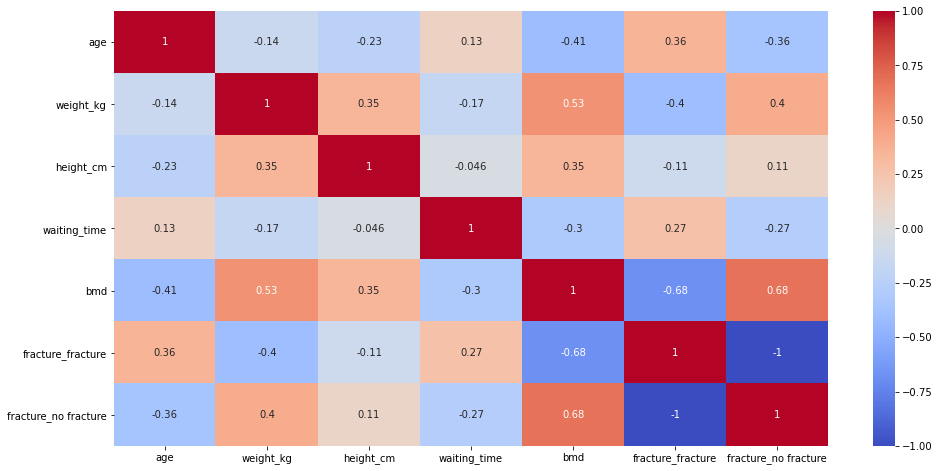

In [39]:
plt.figure(figsize=(16,8))
sns.heatmap(df_encoded.corr(),annot=True, cmap='coolwarm')
plt.show()

Heatmap shows the correlation coeff between each pair of columns. Values range from -1 to 1.
* -1, perfect negative correlation
* 0, no correlation
* 1, perfect positive correlation. 

### In our plot, we can see that:

* There is a strong positive correlation between bmd and no fracture (0.68), indicatng that individuals with higher BMD are more likely to get no fractures. So, lower the BMD, more likely to get fractures.

* There is a positive correlation between age and fracture (0.36), indicating that older individuals are more likely to get fractures. 

* There is a  positive correlation between weight and no fracture (0.36), suggesting that heavier individuals may be less prone to fractures.
 




/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


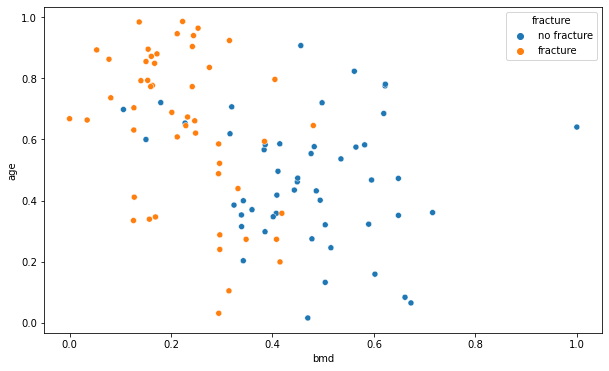

In [40]:
#EDA
plt.figure(figsize=(10,6))

sns.scatterplot(df_downsampled.bmd, df_downsampled.age, hue=df_downsampled.fracture)
plt.show()

* We observe that individuals who have got fractures are more likely to be older and have lower BMD.

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


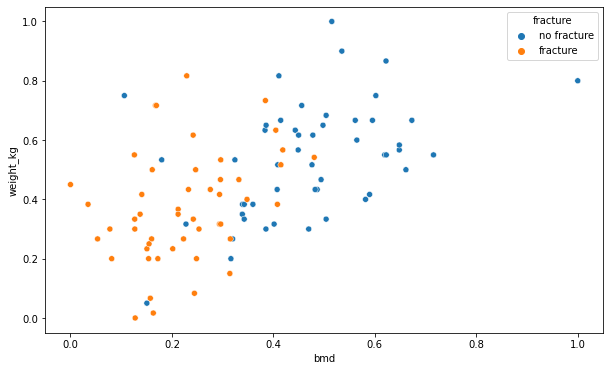

In [41]:
#EDA
plt.figure(figsize=(10,6))

sns.scatterplot(df_downsampled.bmd, df_downsampled.weight_kg, hue=df_downsampled.fracture)
plt.show()

* We observe that individuals who are categorized as "No Fracture" are more likely to have a higher weight compared to those who have a fracture.

# Split to X & Y 

In [42]:
# Set Features and Target Variable
x = df_downsampled[['age', 'weight_kg','height_cm','bmd']]
y = df_downsampled['fracture']

# KNN

* Supervised method - to help you determine how to classify
* Uses proximity to make predictions
* Goal: to identify the nearest neighbors of the new data point, so we can determine the class to which we will assign the new dat point to 


#### Difference between Logistic & KNN:
* LR: Selecting regulator ie Ridge/Lasso
* KNN: User has to input parameter 'k'


# Determine K value 

* How many neighbors will we check to determine the classification of the new data point.
* Different values can lead to overfitting or underfitting.

##### NOTE:
* Can't choose 1. Too small & limiting. 
* Next 2. Even numbers are generally avoided as you cannot pick one of the two classification decidedly. Hence, it is advisable to pick odd number so we can pick the class with more..

## To determine 'k', there are 2 methods:

#### 1. Square root of N (N = number of samples) - Traditional method

* Used more as a starting point

For eg, in our dataset we have 100 observations after downsampling. So, the square root of 100 is 10. So we start with k = 10.  We will also check for 9 and 11.


#### 2. Derive a plot between Error rate and K denoting values in a defined range. Then choose the K value with a minimum error rate.








# METHOD 1 (Square root of N)

##### Checking accuracy with 3 different values of K: 10, 9, 11

### Create the KNN model

In [43]:
# Set the number of nearest neighbors to consider
k = 10  
knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')

# Common distances metrics used:

To determine which data points are closest to a given new data point, the distance between the new data point and the other data points will need to be calculated.


* Euclidean
* Manhattan
* Chebyshev
* Mahalanobis 

Reference:https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html



### Model Fitting

In [44]:
# Fit the model
knn.fit(x, y)

KNeighborsClassifier(metric='euclidean', n_neighbors=10)

### Prediction on Test data


In [45]:
y_pred = knn.predict(x)

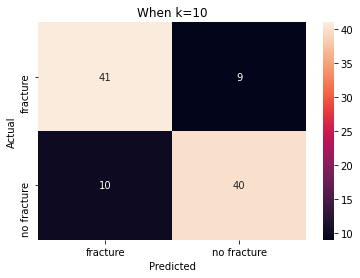

In [46]:
confusion_matrix = pd.crosstab(y, y_pred, rownames=['Actual'], colnames=['Predicted'])
#print(confusion_matrix)

sns.heatmap(confusion_matrix, annot=True)
plt.title('When k=10')

plt.show()


### 41+40 correct predictions (81 correctly clasified patients) and 10+9 incorrect predictions (19 incorrectly classified patients).


From the confusion matrix, we can see that the KNN algorithm classified 41 correct predictions for the "fracture" class and 40 correct predictions for the "no fracture" class. 
It made 10 incorrect predictions for the "fracture" class, which were classified as "no fracture", and 9 incorrect predictions for the "no fracture" class, which were classified as "fracture".

# Evaluating the Model using Accuracy Score



In [47]:
# Calculate accuracy of the model
accuracy = accuracy_score(y, y_pred)
print('Accuracy for k = 10 :', accuracy)

Accuracy for k = 10 : 0.81


####  k = 10, accuracy score = 0.81

# WHEN k =  9

In [48]:
# KNN classifier with 9 neighbors 
knn = KNeighborsClassifier(n_neighbors=9, metric='euclidean')

# Fit the model
knn.fit(x, y)

# Predict
y_pred = knn.predict(x)

# Calculate accuracy of the model
accuracy = accuracy_score(y, y_pred)
print('Accuracy for k = 9 :', accuracy)

Accuracy for k = 9 : 0.79


#### k = 9, accuracy score = 0.79

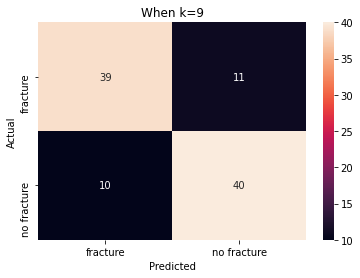

In [49]:
confusion_matrix = pd.crosstab(y, y_pred, rownames=['Actual'], colnames=['Predicted'])
#print(confusion_matrix)

sns.heatmap(confusion_matrix, annot=True)
plt.title('When k=9')
plt.show()


### 39+40 correct predictions (79 correctly clasified patients) and 10+11 incorrect predictions (21 incorrectly classified patients).


# WHEN k = 11

In [50]:
# KNN classifier with 11 neighbors
knn = KNeighborsClassifier(n_neighbors=11, metric='euclidean')

# Fit the model
knn.fit(x, y)

# Predict
y_pred = knn.predict(x)

# Calculate accuracy of the model
accuracy = accuracy_score(y, y_pred)
print('Accuracy for k = 11 :', accuracy)

Accuracy for k = 11 : 0.8


#### k = 11, accuracy score = 0.8

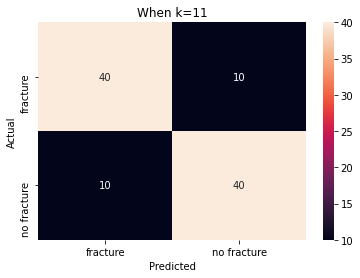

In [51]:
confusion_matrix = pd.crosstab(y, y_pred, rownames=['Actual'], colnames=['Predicted'])
#print(confusion_matrix)

sns.heatmap(confusion_matrix, annot=True)
plt.title('When k=11')
plt.show()

### 40+40 correct predictions (80 correctly clasified patients) and 10+10 incorrect predictions (20 incorrectly classified patients).


# Analyze results for multiple K values

#### 1. In terms of Accuracy Score
* k = 9 ; 0.79
* k = 10 ; 0.81
* k = 11 ; 0.8 

### So, k = 10 is the better performer in terms of accuracy score. 

#### 2. In terms of Confusion Matrix
* k = 9 ;  39+40 correct predictions (79 correctly clasified patients) and 10+11 incorrect predictions (21 incorrectly classified patients).
* k = 10 ; 41+40 correct predictions (81 correctly clasified patients) and 10+9 incorrect predictions (19 incorrectly classified patients).
* k = 11 ; 40+40 correct predictions (80 correctly clasified patients) and 10+10 incorrect predictions (20 incorrectly classified patients).



### So, k = 10 is the better performer in terms of confusion matrix as it correctly classified 81 patients and incorrectly classified only 19 incorrect patients - which is the best result out of them all.





____

# METHOD 2 (Classifier Error Rate)

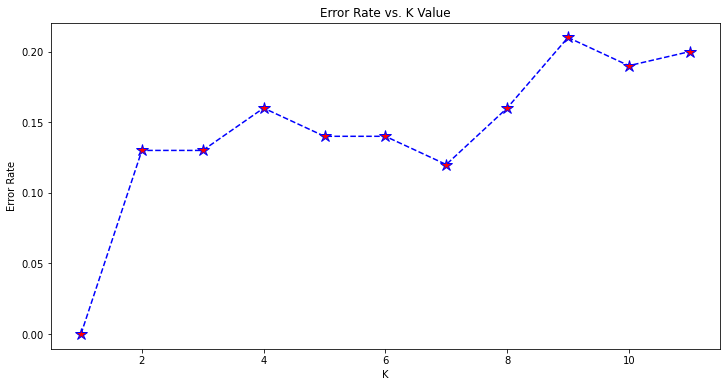

In [52]:
#Determine classifier error rate
error_rate = []
for i in range(1,12):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(x, y)
    #Y_pred=knn.predict(X)
    pred_i = knn.predict(x)
    error_rate.append(np.mean(pred_i != y))
    
plt.figure(figsize=(12,6))
plt.plot(range(1,12),error_rate,color='blue', linestyle='dashed', marker='*',
markerfacecolor='red', markersize=12)

plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
plt.show()


# From the plot, we can see that the smallest error we got is at K=7.


Ideally, we want to pick the one with the lowest error rate. But we can't pick 1 as it is not sufficient, so we exclude 1.


In [53]:
# KNN classifier object with 7 neighbors 
knn = KNeighborsClassifier(n_neighbors=7, metric='euclidean')

# Fit the model
knn.fit(x, y)

# Predict
y_pred = knn.predict(x)

# Calculate accuracy of the model
accuracy = accuracy_score(y, y_pred)
print('Accuracy for k = 7 :', accuracy)

Accuracy for k = 7 : 0.88


#### k = 7, accuracy score = 0.88

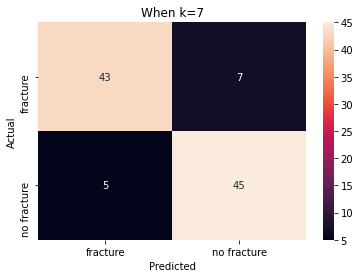

In [54]:
confusion_matrix = pd.crosstab(y, y_pred, rownames=['Actual'], colnames=['Predicted'])
#print(confusion_matrix)

sns.heatmap(confusion_matrix, annot=True)
plt.title('When k=7')
plt.show()

### 43+45 correct predictions (88 correctly clasified patients) and 5+7 incorrect predictions (12 incorrectly classified patients).


From the confusion matrix, we can see that the KNN algorithm classified 43 correct predictions for the "fracture" class and 45 correct predictions for the "no fracture" class. 
It made 5 incorrect predictions for the "fracture" class, which were classified as "no fracture", and 7 incorrect predictions for the "no fracture" class, which were classified as "fracture".

#### So, using both the methods for determining the value of K, we checked for k = 7, 9, 10, 11

## Ultimtely, the one with the best results was k =7, in terms of accuracy score and confusion matrix (correct and incorrect classifications)

___


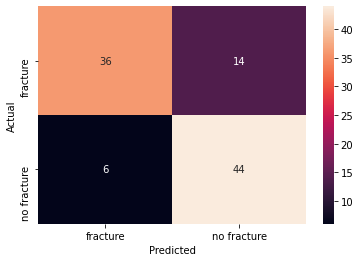

Accuracy for Logistic Regression =  0.8


In [55]:
#Recap result of Logistic Regression

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Create LR model
model_LR = LogisticRegression()

# Fit the model 
model_LR.fit(x,y)

y_predict = model_LR.predict(x)

# Confusion matrix
confusion_matrix = pd.crosstab(y, y_predict, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)
plt.show()

# Accuracy Score of LR
accuracy = metrics.accuracy_score(y,y_predict)
print('Accuracy for Logistic Regression = ', accuracy)

# Comparison of Logistic Regression & KNN:

#### 1. In terms of Accuracy Score

Comparing the KNN algorithm's performance with logistic regression, we can see that logistic regression achieved an accuracy of 0.80. Therefore, KNN (when k = 7, accuracy score = 0.88) performed better than logistic regression in terms of classification accuracy.


#### 2. In terms of classfications:

#### Correct Classifications:
* KNN:88 correct predictions
* LR: 80

#### Incorrect/Missclassifications:
* KNN: 12 incorrect predictions
* LR: 20


So, KNN had more correct classifications & less missclssifications compared to Logistic Regression. Hence, KNN is the better model!